# Lesson 2: Orbits and Time
In Lesson 1 we visualized the shape of an orbit using the polar orbit equation:

$$
r = \frac{a(1-e^2)}{1 + e\cos{\theta}}
$$

Where `a, e, theta` are the semi-major axis (orbit size), eccentricity (orbit shape), and true anomaly (where in the orbit we are).

We even included three other orbital elements `i, raan, argp` that orient the orbit plane in space to draw out the ground track on a map.

However we neglected one critical element that made our ground track wrong: __time__. Time does not appear anywhere in our function in Lesson 1, but it's really important.

In this lesson we're going to dive into how we get time into our orbit trajectory so that we can finally make an accurate ground track, among other things.

First, get all of our imports and constants out of the way for later use:

In [1]:
import utilities_l2 as utils

import math
import matplotlib.pyplot as plt

RADIUS_EARTH = 6371008.0
MU_EARTH = 398600441500000.0
EARTH_ROTATION_RATE = -7.292123e-5
RADIAN_TO_DEGREE = 57.2957795131
DEGREE_TO_RADIAN = 0.01745329251

## 2.1 Eccentric and Mean Anomalies
Before we start talking about time, we need to introduce two more quantities:
- `E` the eccentric anomaly
- `M` the mean anomaly

These quantities are measured in radians just like true anomaly (`theta`). `E` has a geometric definition as an angle, but it doesn't really matter for our understanding.

`M` on the other hand is not strictly an angle, rather it's the fraction of an orbit's _period_ that has elapsed. `M` is how we're going to get to time, since we know the period (time for a full orbit) from the semi-major axis (`a`).

The relationships between the three anomalies and time are fairly straightforward equations:

$$
E = 2\tan^{-1}\Big(\sqrt{\frac{1-e}{1+e}}\tan{\frac{\theta}{2}}\Big)
$$

$$
M = E - e\sin{E}
$$

$$
t = M\sqrt{\frac{a^3}{\mu}}
$$

That's a lot, so let's review all of the different quantities in these three equations:
- `t`: time, technically the time past perigee, but can be shifted easily
- `theta`: true anomaly, angle between perigee and current location in orbit
- `E`: eccentric anomaly, an irrelevant angle (for our purposes)
- `M`: mean anomaly, the fraction of an orbit period elapsed, expressed as an angle
- `e`: eccentricy, an orbital element
- `a`: semimajor axis, an orbital element
- `mu`: earth gravitational parameter (a constant)

### 2.1.1 Anomaly Conversion Functions

We're going to define three functions that implement the three equations above to convert from true anomaly (`theta`) to time (`t`) in steps. We'll then add a fourth function to stitch the steps together. Our three steps will be:

$$
\theta \rightarrow E \rightarrow M \rightarrow t
$$

If you want, replace each of the lines with `utils...` with your own implementation (reccomend against this for `true_anom_to_eccentric_anom` due to `atan` annoyances).

In [2]:
def true_anom_to_eccentric_anom(theta, e):
    E = utils.true_anom_to_eccentric_anom(theta, e)
    return E


def eccentric_anom_to_mean_anom(E, e):
    M = utils.eccentric_anom_to_mean_anom(E, e)
    return M


def mean_anom_to_time(M, a):
    t = utils.mean_anom_to_time(M, a)
    return t


def true_anom_to_time(theta, a, e):
    t = utils.true_anom_to_time(theta, a, e)
    return t

### 2.1.2 Plotting Anomolies
Let's plot true and mean anomaly against time (eccentric anomaly isn't critical to the discussion, it's more the middleman that gets us where we want to go).

How does changing `a` change the plot? Changing `e`?

Set `e` to a high value like `0.8`. Why is the slope of the `theta` lines so high at the beginning and end?

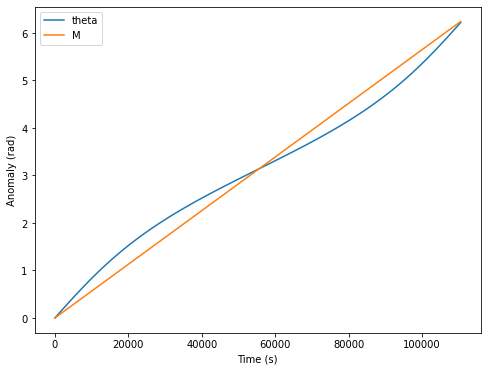

In [3]:
e = 0.2
a = 50000000

theta_list = []
E_list = []
M_list = []
t_list = []

N = 101 # number points to plot

for i in range(N):
    theta = i * 2 * math.pi / N
    E = true_anom_to_eccentric_anom(theta, e)
    M = eccentric_anom_to_mean_anom(E, e)
    t = mean_anom_to_time(M, a)
    
    theta_list.append(theta)
    E_list.append(E)
    M_list.append(M)
    t_list.append(t)
    
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(t_list, theta_list, label="theta")
ax.plot(t_list, M_list, label="M")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Anomaly (rad)")
ax.legend()
plt.show()

## 2.2 Ground Track - Second Attempt
Amazingly, we have now enough done enough work to correct our orbit ground track from Lesson 1. This is a five step process:

1. Calculate the trajectory in inertial space just like we did in Lesson 1 and convert that trajectory to latitude/longitude coordinates. Nothing new here.
2. Calculate the elapsed time at each point in our trajectory using the conversion functions above.
3. Calculate how much the earth has rotated since `t=0`. The earth rotates at constant rate, so this isn't hard.
4. Shift the trajectory longitude value at each step by however much the earth has rotated at that time.
5. Plot the latitude and shifted longitude on top of a 2D map.

Note: that Step 4 is kind of a hack, so you should not try rotations like this at home.

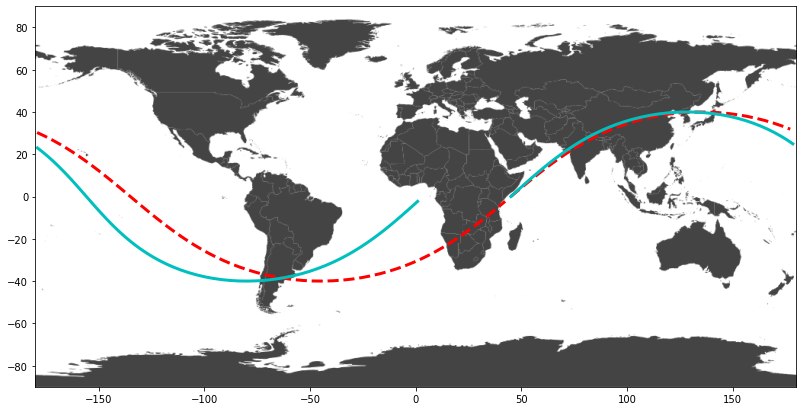

In [4]:
# variables you can change
a = 10000000
e = 0.3
i = 40 * DEGREE_TO_RADIAN
raan = 45 * DEGREE_TO_RADIAN
argp = 0 * DEGREE_TO_RADIAN
N = 101 # number of theta values to plot

# these are empty lists that we will append data to in the loop below
lat_list = []
lon_list_original = []
lon_list_corrected = []

# the for loop steps through each value of theta
for j in range(N):
    theta = j * 2 * math.pi / N
    
    # step 1 - calculate x,y,z in inertial then lat/lon
    x, y, z, vx, vy, vz = utils.convert_kepler_to_cartesian(a, e, i, raan, argp, theta)
    lat, lon, alt = utils.convert_cartesian_to_lla(x, y, z)
    
    # step 2 - calculate elapsed time since start
    t = true_anom_to_time(theta, a, e)
    
    # step 3 - calculate earth rotation angle
    earth_rotation = t * EARTH_ROTATION_RATE
    
    # step 4 - modify longitude by earth rotation angle
    lon_corrected = lon + earth_rotation
    
    # make sure corrected longitude falls in -pi,pi interval (i.e. -180, 180 deg)
    lon_corrected = (lon_corrected + math.pi) % (2 * math.pi) - math.pi
    
    lat_list.append(lat)
    lon_list_original.append(lon)
    lon_list_corrected.append(lon_corrected)
    
# step 5 - plot
ax = utils.add_latlon_trajectory(lat_list, lon_list_original, color="r--")
ax = utils.add_latlon_trajectory(lat_list, lon_list_corrected, ax=ax, color="c")

## 2.3 Keplers Equation
The work above allows us to go from true anomaly `theta` to time `t`. This allows us to the answer the question:
- Given the satellite is at location `x`, what is the time `t`?

But what if we want to answer the inverse question:
- Given the time is `t`, what is the satellite location `x`?

The difference between these questions is subtle, but very important. As an example, the (presumably) common question _"where is my satellite right now?"_ is a derivative of the second question only.

Let's see if we can invert the three equations above so that we can go the opposite direction from time to true anomaly: $ t \rightarrow M \rightarrow E \rightarrow \theta $

Inverting the third equation is the easiest:

$$
M = t\sqrt{\frac{\mu}{a^3}}
$$

Inverting the first equation is just algebra:

$$
\theta = 2\tan^{-1}\Big(\sqrt{\frac{1+e}{1-e}}\tan{\frac{E}{2}}\Big)
$$

But inverting the second equation is...impossible. If you can do it, then you will have solved a problem that has interested mathematicians (e.g. Kepler, Newton, Lagrange) since the 17th century, and has motivated some major advances in mathematics.

The second equation is called _Kepler's Equation_ and has no closed form solution for `E`:

$$
M = E - e\sin{E}
$$

However, all is not lost: there are several ways to solve for `E`, one of which we'll explore here.


### 2.3.1 Visualizing Kepler's Equation
First, let's rewrite Kepler's equation by moving `M` over to the right side of the equation and using function notation:

$$
f(M,e,E) = E - e\sin{E} - M
$$

Let's see what $f(M,e,E)$ looks like for fixed `M,e` and variable `E`. Replace the `utils...` statements in the definitions below if you'd like:

In [5]:
def kepler_function(M, e, E):
    f = utils.kepler_function(M, e, E)
    return f

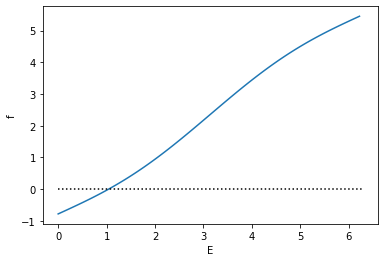

In [6]:
e = 0.3
M = math.pi / 4

f_list = []
E_list = []

for j in range(100):
    E = j * 2 * math.pi / 100
    f = kepler_function(M, e, E)
    
    E_list.append(E)
    f_list.append(f)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(E_list, f_list)
ax.plot([0, 2*math.pi], [0,0], "k:")
ax.set_xlabel("E")
ax.set_ylabel("f")
plt.show()

### 2.3.2 Newton's Method
When we solve Kepler's equation we find the value of `E` given `M,e` where $ f = 0$. 

This is called finding the "zero" or "root" of a function, and there are many methods that can help us do this. One of the simplest (and most powerful) is called _Newton's Method_.

[Newton's Method](https://en.wikipedia.org/wiki/Newton%27s_method) is an _iterative_ method, which means we do the same thing a bunch of times to approximate the solution until we are happy that we are close enough to the real thing.

Here is Newton's Method in terms of the variables in the equation above:

$$
E_{i+1} = E_i - \frac{f(E_i)}{f\prime(E_i)}
$$

Two points of order: we removed `M,e` from the function inputs, since they are constants. Second, if it's been a while since (or you've never) taken calculus, then you may be frightened by that $f\prime(E_i)$ in the denominator. It means the _first derivative_ of $f$.

Here's an animation ([credit](https://commons.wikimedia.org/wiki/File:NewtonIteration_Ani.gif)) that shows how successive iterations of Newton's Method get us to the function zero:

<img src="images/NewtonIteration_Ani.gif" width="500"/>

Implementing Newton's Method ourselves to solve for `E` is not bad. We're going to define two functions: `kepler_function_prime` that returns $f\prime$ and `newton_kepler_step` that takes us one iteration forward in Newton's method. As usual, replace the `utils...` lines with your own implementation if you'd like.

In [10]:
def kepler_function_prime(M, e, E):
    # replace with your own implementation if you'd like
    # remember we're taking the derivative with respect to E
    f_prime = utils.kepler_function_prime(M, e, E)
    return f_prime

def newton_kepler_step(M, e, E):
    # replace with your own implementation if you'd like (recommend multiple lines)
    E_next = utils.newton_kepler_step(M, e, E)
    return E_next

### 2.3.3 Solving Kepler's Equation
At this point we have almost everything we need to solve for `E` by using `newton_kepler_step` to compute the next iteration. We are only missing two things:
1. Where do we start for the first iteration of `E`, $E_0$?
2. When do we stop iterating?

Question #1 is very important for any application of Newton's Method, since initial guesses too far away from the root could either diverge or converge to the wrong root. For this application, we will use $E_0=\pi$ for all cases, which converges for all cases except eccentrities close to 1.

Question #2 depends on how accurate we want our solution to be. For our purposes, if we are within $1\times10^{-6}$ of the root then we will call that good enough.

The function `newton_kepler_solve` below returns the value of `E` that solves Kepler's Equation for a particular value of `M,e`.

In [11]:
def newton_kepler_solve(M, e):
    max_iter = 20
    E = math.pi
    tol = 1e-6
    
    i = 0
    
    while i < max_iter:
        E = newton_kepler_step(M, e, E)
        err = kepler_function(M, e, E)
        
        if err < tol:
            return E
        
        i += 1
        
    print("Did not find solution for M={}, e={}".format(M,e))
    return None

Now we can plot our solution for `E` on top of the full curve visualized.

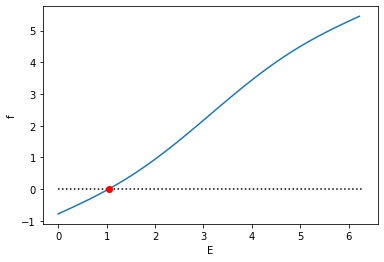

In [16]:
e = 0.3
M = math.pi / 4

E_soln = newton_kepler_solve(M, e)
f_soln = kepler_function(M, e, E_soln)

f_list = []
E_list = []

for j in range(100):
    E = j * 2 * math.pi / 100
    f = kepler_function(M, e, E)
    
    E_list.append(E)
    f_list.append(f)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(E_list, f_list)
ax.plot([0, 2*math.pi], [0,0], "k:")
ax.plot(E_soln, f_soln, "ro")
ax.set_xlabel("E")
ax.set_ylabel("f")
plt.show()

## 2.4 Orbit Propagation in Time

## 2.5 Equations of Motion

## 2.6 Simple Numerical Integration

## 2.7 Accurate Numerical Integration

## 2.8 Kepler or Integration?

In [7]:
import importlib as il
il.reload(utils)

<module 'utilities_l2' from '/home/peter/Projects/orbit-learning/utilities_l2.py'>